# <center> Проект 3: Прогнозирование рейтинга отеля на Booking

## 1. Постановка задачи: Повышение качества предсказания (MAPE<0.14)

В представленном датасете содержатся сведения о 515 000 отзывов на отели Европы. Модель, которую предстоит обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных.

Данные содержат следующие столбцы:

* *hotel_address* — адрес отеля;  
* *review_date* — дата, когда рецензент разместил соответствующий отзыв;  
* *average_score* — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* *hotel_name* — название отеля;  
* *reviewer_nationality* — страна рецензента;  
* *negative_review* — отрицательный отзыв, который рецензент дал отелю;  
* *review_total_negative_word_counts* — общее количество слов в отрицательном отзыв;  
* *positive_review* — положительный отзыв, который рецензент дал отелю;  
* *review_total_positive_word_counts* — общее количество слов в положительном отзыве;  
* *reviewer_score* — оценка, которую рецензент поставил отелю на основе своего опыта;  
* *total_number_of_reviews_reviewer_has_given* — количество отзывов, которые рецензенты дали в прошлом;  
* *total_number_of_reviews* — общее количество действительных отзывов об отеле;  
* *tags* — теги, которые рецензент дал отелю;  
* *days_since_review* — количество дней между датой проверки и датой очистки;  
* *additional_number_of_scoring* — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки;  
* *lat* — географическая широта отеля;  
* *lng* — географическая долгота отеля.

## 2. Импорт библиотек и загрузка данных

In [2]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split   # загружаем специальный удобный инструмент для разделения датасета:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor   # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели 

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import category_encoders as ce

from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2 # хи-квадрат

In [32]:
# фиксируем версию пакетов для воспроизводимости результатов
!pip freeze > requirements.txt

In [3]:
# загружаем тренировочные данные
df_train = pd.read_csv('hotels_train.csv')

df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [4]:
# загружаем тестовые данные
df_test = pd.read_csv('hotels_test.csv')

df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [5]:
# загружаем сабмишн
df_sub = pd.read_csv('submission.csv')

df_sub.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [7]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [8]:
# сделаем вывод главы "2. Импорт библиотек и загрузка данных"

missing_data_tain = df_train.isnull()
missing_data_tain.sum()
nan_col_train = 'Столбцы с пустрыми ячейками (df_train):'
for i in missing_data_tain.columns:
    if missing_data_tain[i].sum() != 0:
        nan_col_train = nan_col_train + f' {i} ({missing_data_tain[i].sum()} ячеек)'

missing_data_test = df_test.isnull()
missing_data_test.sum()
nan_col_test = 'Столбцы с пустрыми ячейками (df_test):'
for i in missing_data_test.columns:
    if missing_data_test[i].sum() != 0:
        nan_col_test = nan_col_test + f' {i} ({missing_data_test[i].sum()} ячеек)'
        
print('Вывод')
print('-' * 35)
print(f'Размерность df_train: {df_train.shape}')
print(nan_col_train)
print(f'Размерность df_test: {df_test.shape}')
print(nan_col_test)

Вывод
-----------------------------------
Размерность df_train: (386803, 17)
Столбцы с пустрыми ячейками (df_train): lat (2448 ячеек) lng (2448 ячеек)
Размерность df_test: (128935, 16)
Столбцы с пустрыми ячейками (df_test): lat (820 ячеек) lng (820 ячеек)


## 3. Очистка и объединение данных

In [6]:
# посчитаем количество дубликатов в df_train и удалим их
print('В датасете {} дубликатов'.format(df_train[df_train.duplicated()].shape[0]))

df_train.drop_duplicates(inplace=True)

print(f'Количество строк после удаления дубликатов составляет: {df_train.shape[0]}')

В датасете 307 дубликатов
Количество строк после удаления дубликатов составляет: 386496


Дубликаты в df_test удалять не будем, чтобы не нарушить соответствие df_sub. Объединим все таблицы, чтобы выполнить преобразования сразу на всем наборе данных.

In [7]:
# объединим тренировочный и тестовый датасеты в одну таблицу

# для начала подготовим таблицы к объединению
df_train['df_test'] = False   
df_test['df_test'] = True   # необходимо создать столбец-идентификатор происхождения данных,

df_test['reviewer_score'] = 0   # а также создать отсутствующий целевой столбец

# объединяем таблицы
hotels = pd.concat([df_train, df_test])

hotels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515431 entries, 0 to 128934
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 10  r

Разберемся с недостающими значениями

In [8]:
# выведем адреса отелей, координаты которых не указаны
hotels_gap = hotels[(hotels.lng.isna()) & (hotels.lat.isna())].groupby(by = ['hotel_address']).count().iloc[:,0]

hotels_gap

hotel_address
20 Rue De La Ga t 14th arr 75014 Paris France                   37
23 Rue Damr mont 18th arr 75018 Paris France                    55
4 rue de la P pini re 8th arr 75008 Paris France               290
Bail n 4 6 Eixample 08010 Barcelona Spain                      146
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria             93
Hasenauerstra e 12 19 D bling 1190 Vienna Austria               61
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria    658
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria        57
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria         245
Paragonstra e 1 11 Simmering 1110 Vienna Austria                49
Pau Clar s 122 Eixample 08009 Barcelona Spain                   33
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria               194
Sep lveda 180 Eixample 08011 Barcelona Spain                    28
Sieveringer Stra e 4 19 D bling 1190 Vienna Austria            147
Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Aust

In [9]:
# создадим таблицу для присоединения к ней данных о координатах
hotels_nan = hotels[hotels.isnull().any(axis=1)][['hotel_address']].value_counts().to_frame()

# данные взяты из источника https://www.gps-coordinates.net/
# добавляем стобец lat
hotels_nan.insert(0, 'lat', [
        48.2167,
        48.2167,
        48.2333,
        48.875257,
        48.1981,
        48.2333,
        48.2167,
        41.3888,
        48.2068,
        48.2333,
        48.884949,
        48.2068,
        48.2167,
        48.2068,
        48.835321,
        41.3888,
        41.3888
])

# добавляем стобец lng
hotels_nan.insert(1, 'lng', [
        16.35,
        16.4,
        16.35,
        2.323375,
        16.3948,
        16.35,
        16.3,
        2.159,
        16.2646,
        16.35,
        2.353604,
        16.2646,
        16.35,
        16.2646,
        2.321463,
        2.159,
        2.159
])

hotels_nan

,lat,lng,count
hotel_address,,,
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,48.216700,16.350000,658
Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria,48.216700,16.400000,563
W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria,48.233300,16.350000,389
4 rue de la P pini re 8th arr 75008 Paris France,48.875257,2.323375,290
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,48.198100,16.394800,245
W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria,48.233300,16.350000,223
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,48.216700,16.300000,194
Sieveringer Stra e 4 19 D bling 1190 Vienna Austria,41.388800,2.159000,147
Bail n 4 6 Eixample 08010 Barcelona Spain,48.206800,16.264600,146


In [10]:
# соединяем таблицы по имени отеля, заполним пропуски и удалим лишние столбцы
# соединяем таблицы по адресу отелей
hotels = hotels.merge(hotels_nan, how='left', on='hotel_address', suffixes=(None, '_'))

# заполняем пропущенные значения
hotels.loc[hotels.lat.isna(), ['lat']] = hotels[hotels.lat.isna()]['lat_']
hotels.loc[hotels.lng.isna(), ['lng']] = hotels[hotels.lng.isna()]['lng_']

# удаляем новые столбцы
hotels.drop(['lat_', 'lng_', 'count'], axis=1, inplace=True)

# проверим изменения в таблице
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

In [11]:
# сделаем вывод главы "2. Очистка данных"
missing_data = hotels.isnull()
missing_data.sum()
num = 0

for i in missing_data.columns:
    if missing_data[i].sum() != 0:
        num += 1
       
print('Вывод')
print('-' * 35)
print('Выполнена очистка данных')
print('Пропуски заполнены')
print(f'Размерность таблицы стала следующей: {hotels.shape}')
print(f'Количество столбцов с пропусками: {num}')

Вывод
-----------------------------------
Выполнена очистка данных
Пропуски заполнены
Размерность таблицы стала следующей: (515431, 18)
Количество столбцов с пропусками: 0


## 4. Исследование структуры данных

In [12]:
# переведем столбец days_since_review из obj в int
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x[0]))

In [13]:
# оценим статистические числовых признаков
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000
mean,498.275079,8.397630,18.539760,2744.259084,17.777342,7.165215,6.296715,3.761695,49.432762,2.893549
std,500.618961,0.548033,29.690973,2317.823718,21.803204,11.038742,3.902967,1.987246,3.461242,4.668450
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.000000,2.000000,48.214662,-0.143372
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,4.000000,51.499981,0.019886
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,9.600000,5.000000,51.516288,4.841163
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,9.000000,52.400181,16.429233


In [22]:
def plot_numerical_feature(data: pd.DataFrame, col: str):
    
    ''' Функция выводит статистические данные числового признака.
    Args:
        data (pd.DataFrame): датасет
        col (str): наименование признака
    Returns:
        None
    '''
    if col != 'df_test':
        print(f'Статистические данные признака {col}:')
        display(data[col].describe().round(2))

In [23]:
# Построение гистограммы распределения каждого числового признака
list_str_sign = []
list_num_sign = []


for sign in hotels.columns:
    if pd.api.types.is_numeric_dtype(hotels[sign].dtype):
        list_num_sign.append(sign)
    elif pd.api.types.is_object_dtype(hotels[sign].dtype):
        list_str_sign.append(sign)

for col in list_num_sign:
    plot_numerical_feature(hotels, col)

Статистические данные признака additional_number_of_scoring:


count    515431.00
mean        498.28
std         500.62
min           1.00
25%         169.00
50%         342.00
75%         660.00
max        2682.00
Name: additional_number_of_scoring, dtype: float64

Статистические данные признака average_score:


count    515431.00
mean          8.40
std           0.55
min           5.20
25%           8.10
50%           8.40
75%           8.80
max           9.80
Name: average_score, dtype: float64

Статистические данные признака review_total_negative_word_counts:


count    515431.00
mean         18.54
std          29.69
min           0.00
25%           2.00
50%           9.00
75%          23.00
max         408.00
Name: review_total_negative_word_counts, dtype: float64

Статистические данные признака total_number_of_reviews:


count    515431.00
mean       2744.26
std        2317.82
min          43.00
25%        1161.00
50%        2134.00
75%        3633.00
max       16670.00
Name: total_number_of_reviews, dtype: float64

Статистические данные признака review_total_positive_word_counts:


count    515431.00
mean         17.78
std          21.80
min           0.00
25%           5.00
50%          11.00
75%          22.00
max         395.00
Name: review_total_positive_word_counts, dtype: float64

Статистические данные признака total_number_of_reviews_reviewer_has_given:


count    515431.00
mean          7.17
std          11.04
min           1.00
25%           1.00
50%           3.00
75%           8.00
max         355.00
Name: total_number_of_reviews_reviewer_has_given, dtype: float64

Статистические данные признака reviewer_score:


count    515431.0
mean          6.3
std           3.9
min           0.0
25%           0.0
50%           7.9
75%           9.6
max          10.0
Name: reviewer_score, dtype: float64

Статистические данные признака days_since_review:


count    515431.00
mean          3.76
std           1.99
min           0.00
25%           2.00
50%           4.00
75%           5.00
max           9.00
Name: days_since_review, dtype: float64

Статистические данные признака lat:


count    515431.00
mean         49.43
std           3.46
min          41.33
25%          48.21
50%          51.50
75%          51.52
max          52.40
Name: lat, dtype: float64

Статистические данные признака lng:


count    515431.00
mean          2.89
std           4.67
min          -0.37
25%          -0.14
50%           0.02
75%           4.84
max          16.43
Name: lng, dtype: float64

In [24]:
def plot_categorical_feature(data: pd.DataFrame, col: str):
    
    ''' Функция выводит статистические данные категориального признака. 
    Args:
        data (pd.DataFrame): датасет
        col (str): наименование признака
        main_title (str): расшифровка наименования признака для вывода
            в титуле графика
    Returns:
        None
    '''
        
    print('Статистические данные признака:')
    display(data[col].describe())
    print('Top-10 значений (%):')
    display(data[col].value_counts(normalize=True).head(10).round(4)*100)

In [25]:
# Построение баров распределения каждого категориального признака
for col in list_str_sign:
    plot_categorical_feature(hotels, col)

Статистические данные признака:


count                                                515431
unique                                                 1493
top       163 Marsh Wall Docklands Tower Hamlets London ...
freq                                                   4789
Name: hotel_address, dtype: object

Top-10 значений (%):


hotel_address
163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              0.93
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     0.83
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     0.81
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    0.69
7 Pepys Street City of London London EC3N 4AF United Kingdom                      0.62
1 Inverness Terrace Westminster Borough London W2 3JP United Kingdom              0.57
Wrights Lane Kensington and Chelsea London W8 5SP United Kingdom                  0.54
225 Edgware Road Westminster Borough London W2 1JU United Kingdom                 0.51
4 18 Harrington Gardens Kensington and Chelsea London SW7 4LH United Kingdom      0.50
1 Waterview Drive Greenwich London SE10 0TW United Kingdom                        0.49
Name: proportion, dtype: float64

Статистические данные признака:


count       515431
unique         731
top       8/2/2017
freq          2584
Name: review_date, dtype: object

Top-10 значений (%):


review_date
8/2/2017     0.50
9/15/2016    0.45
4/5/2017     0.44
8/30/2016    0.38
2/16/2016    0.38
7/5/2016     0.37
5/31/2016    0.36
12/5/2016    0.35
7/12/2016    0.35
8/2/2016     0.35
Name: proportion, dtype: float64

Статистические данные признака:


count                                         515431
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            4789
Name: hotel_name, dtype: object

Top-10 значений (%):


hotel_name
Britannia International Hotel Canary Wharf           0.93
Strand Palace Hotel                                  0.83
Park Plaza Westminster Bridge London                 0.81
Copthorne Tara Hotel London Kensington               0.69
DoubleTree by Hilton Hotel London Tower of London    0.62
Grand Royale London Hyde Park                        0.57
Holiday Inn London Kensington                        0.54
Hilton London Metropole                              0.51
Millennium Gloucester Hotel London                   0.50
Intercontinental London The O2                       0.49
Name: proportion, dtype: float64

Статистические данные признака:


count               515431
unique                 227
top        United Kingdom 
freq                245165
Name: reviewer_nationality, dtype: object

Top-10 значений (%):


reviewer_nationality
 United Kingdom               47.57
 United States of America      6.87
 Australia                     4.20
 Ireland                       2.88
 United Arab Emirates          1.98
 Saudi Arabia                  1.74
 Netherlands                   1.70
 Switzerland                   1.68
 Germany                       1.54
 Canada                        1.53
Name: proportion, dtype: float64

Статистические данные признака:


count          515431
unique         330011
top       No Negative
freq           127816
Name: negative_review, dtype: object

Top-10 значений (%):


negative_review
No Negative    24.80
 Nothing        2.77
 Nothing        0.82
 nothing        0.43
 N A            0.20
 None           0.19
                0.16
 N a            0.10
 Breakfast      0.08
 Small room     0.07
Name: proportion, dtype: float64

Статистические данные признака:


count          515431
unique         412601
top       No Positive
freq            35924
Name: positive_review, dtype: object

Top-10 значений (%):


positive_review
No Positive        6.97
 Location          1.79
 Everything        0.44
 location          0.32
 Nothing           0.24
 The location      0.22
 Great location    0.20
 Good location     0.18
 Location          0.18
 Everything        0.12
Name: proportion, dtype: float64

Статистические данные признака:


count                                                515431
unique                                                55242
top       [' Leisure trip ', ' Couple ', ' Double Room '...
freq                                                   5101
Name: tags, dtype: object

Top-10 значений (%):


tags
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']              0.99
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']     0.96
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']     0.85
[' Leisure trip ', ' Couple ', ' Deluxe Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']       0.77
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']             0.64
[' Leisure trip ', ' Couple ', ' Superior Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']    0.60
[' Leisure trip ', ' Couple ', ' Standard Double Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']    0.57
[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ']                                                  0.56
[' Leisure trip ', 

In [26]:
# для формата времени

# переведем столбец review_date в формат date
hotels['review_date'] = pd.to_datetime(hotels['review_date']).dt.date

min = hotels['review_date'].min()
max = hotels['review_date'].max()

print(f'Статистические данные признака "review_date":')
display(hotels['review_date'].describe())
print(f'Дата самого раннего отзыва: {min}')
print(f'Дата самого позднего отзыва: {max}')
print('Top-5 значений (%):')
display(hotels['review_date'].value_counts(normalize=True).head(5).round(4)*100)
print(f'Дата самого раннего отзыва: {min}')
print(f'Дата самого позднего отзыва: {max}')

Статистические данные признака "review_date":


count         515431
unique           731
top       2017-08-02
freq            2584
Name: review_date, dtype: object

Дата самого раннего отзыва: 2015-08-04
Дата самого позднего отзыва: 2017-08-03
Top-5 значений (%):


review_date
2017-08-02    0.50
2016-09-15    0.45
2017-04-05    0.44
2016-08-30    0.38
2016-02-16    0.38
Name: proportion, dtype: float64

Дата самого раннего отзыва: 2015-08-04
Дата самого позднего отзыва: 2017-08-03


**<center> Вывод**

In [24]:
# посмотрим что можно извлечь из признака hotel_address
hotels['hotel_address'].apply(lambda x: str(x.split()[-5:])).value_counts()

hotel_address
['Innere', 'Stadt', '1010', 'Vienna', 'Austria']        12439
['8th', 'arr', '75008', 'Paris', 'France']              11119
['Central', 'Station', '20124', 'Milan', 'Italy']       10928
['Ciutat', 'Vella', '08002', 'Barcelona', 'Spain']       8125
['1st', 'arr', '75001', 'Paris', 'France']               5539
                                                        ...  
['Center', '1017', 'JW', 'Amsterdam', 'Netherlands']       17
['34', 'Eixample', '08010', 'Barcelona', 'Spain']          14
['Palmanova', '153', '20132', 'Milan', 'Italy']            12
['London', 'E2', '7DD', 'United', 'Kingdom']               12
['ois', 'Ory', '92120', 'Paris', 'France']                 10
Name: count, Length: 715, dtype: int64

- Самым оптимальным вариантом будет извлечение названия города, название страны в этом случае будет излишним.

In [25]:
# установим свойство признака additional_number_of_scoring
hotels['additional_number_of_scoring'][hotels['hotel_name'] == 'The May Fair Hotel']

0         581
3250      581
3592      581
4362      581
4981      581
         ... 
514032    581
514156    581
514887    581
515157    581
515249    581
Name: additional_number_of_scoring, Length: 800, dtype: int64

- Этот столбец отображает общее количество оценок без комментариев, отображает количество посетителей, желание поставить оценку без комментария. Для каждого отдельного отеля существует постоянная величина этого признака. Можно получить отношение количества отзывов с комментариями к оценкам без комментариев.

- Из признака review_date можно выделить месяц, год, день недели, а также можно сравнить месяц с информацией о высоком сезоне местности.

In [26]:
# установим свойство признака average_score
hotels['average_score'][hotels['hotel_name'] == 'The May Fair Hotel']

0         8.4
3250      8.4
3592      8.4
4362      8.4
4981      8.4
         ... 
514032    8.4
514156    8.4
514887    8.4
515157    8.4
515249    8.4
Name: average_score, Length: 800, dtype: float64

- Этот признак константен по отношению к названию отлеля. Средний балл отеля, рассчитанный на основе последнего комментария за последний год, скорее имеет случайный характер и вряд ли может влиять на reviewer_score.

- Теоретически, присутствие в названии отеля слова Hotel может увеличить узнаваемость предназначения здания среди неместных.

- Можно извлечь из признака reviewer_nationality информацию об осведомленности отелем, свободе выбора и необычность местости для посетителей. Можно разделить посетителей на местный, неместных европейцев и неевропейцев.

- Можно разделить признак negative_review на отзывы типа 'No negative' от остальных. Так мы разделим отзывы с претензиями от отзывов без претензий.

In [27]:
# посмотрим на признак review_total_negative_word_counts
hotels['review_total_negative_word_counts'].describe()

count    515431.000000
mean         18.539760
std          29.690973
min           0.000000
25%           2.000000
50%           9.000000
75%          23.000000
max         408.000000
Name: review_total_negative_word_counts, dtype: float64

- Количество (review_total_negative_word_counts) знаков может говорить о серьезности проблем с обслуживанием и комфортом, но также это отображает личные характеристики ревьюера.

In [28]:
# установим свойство признака total_number_of_reviews
hotels['total_number_of_reviews'][hotels['hotel_name'] == 'The May Fair Hotel']

0         1994
3250      1994
3592      1994
4362      1994
4981      1994
          ... 
514032    1994
514156    1994
514887    1994
515157    1994
515249    1994
Name: total_number_of_reviews, Length: 800, dtype: int64

- Этот признак отражает количество посетителей отеля. Этот признак может быть связан с возрастом отеля, его размером, популярностью местности и ценой.

- Можно разделить признак positive_review на отзывы типа 'No positive' от остальных. Так мы разделим отзывы с хорошими отзывами от отзывов позитивной оценки.

- Признак total_number_of_reviews_reviewer_has_given отображает активность посетителя в качестве ревьюера, а также может отражать их туристическую активность и некоторую осведомленность в отелях. 

- Из признака tags можно извлечь информацию об особенностях отдыха.

- Продолжительность между датой проверки и датой очистки не кажется информативным для оценки (days_since_review). 

- Кажется, что координаты не являются очень информативным признаком в случае, если есть информация о городе. Можно попробовать оценить влияние оценки в зависимости от удаленности от центра города. Можно рассчитать.

## 5. Создание новых признаков

### Извлечение признаков из hotel_address

In [29]:
# скопируем таблицу
hotels_cleaned = hotels.copy(deep=True)

In [30]:
# создадим признак city
hotels_cleaned['city'] = hotels_cleaned['hotel_address'].apply(lambda x: x.split()[-2] if x.split()[-1] != 'Kingdom' else ' '.join(x.split()[-5]))

# для служебных целей создадим признак country
hotels_cleaned['country'] = hotels_cleaned['hotel_address'].apply(lambda x: x.split()[-1] if x.split()[-1] != 'Kingdom' else ' '.join(x.split()[-2:]))

### Извлечение признаков из additional_number_of_scoring

In [31]:
# создадим новый признак comment_score
# для этого создадим столбец с количеством отзывов
df = hotels_cleaned.groupby(by = ['hotel_name','additional_number_of_scoring']).count().iloc[:,0].reset_index()
df = df.rename(columns={'hotel_address': 'count'})
df['comment_score'] = df['additional_number_of_scoring']/df['count']   # создадим некую относительную величину

df

,hotel_name,additional_number_of_scoring,count,comment_score
0,11 Cadogan Gardens,101,159,0.635220
1,1K Hotel,69,148,0.466216
2,25hours Hotel beim MuseumsQuartier,391,689,0.567489
3,41,66,103,0.640777
4,45 Park Lane Dorchester Collection,27,28,0.964286
...,...,...,...,...
1489,citizenM London Bankside,804,1517,0.529993
1490,citizenM London Shoreditch,500,838,0.596659
1491,citizenM Tower of London,832,1683,0.494355
1492,every hotel Piccadilly,326,568,0.573944


In [30]:
# запишем значения в столбец comment_score
dict_ = {}

for i in df['hotel_name'].unique():
    dict_[i] = df.loc[df['hotel_name']==i,'comment_score'].values[0]

hotels_cleaned['comment_score'] = hotels_cleaned['hotel_name'].apply(lambda x: dict_[x])

### Извлечение признаков из review_date

In [31]:
# создадим признаки year, month, weekday
hotels_cleaned['year'] = pd.to_datetime(hotels_cleaned['review_date']).dt.year
hotels_cleaned['month'] = pd.to_datetime(hotels_cleaned['review_date']).dt.month
hotels_cleaned['weekday'] = pd.to_datetime(hotels_cleaned['review_date']).dt.dayofweek   # Monday=0, Sunday=6.

In [32]:
# создадим признак favorable_season
country_dict = {'United Kingdom':[5,6,7,8,9], 'France':[4,5,6,9,10,11], 'Netherlands':[3,4,5,6,7,8],
                'Italy':[4,5,6,9,10], 'Austria':[4,5,9,10], 'Spain':[3,4,5,9,10]}   # согласно сайту Booking.com

hotels_cleaned['favorable_season'] = 0

for i in country_dict:
    #hotels_cleaned['favorable_season'][hotels_cleaned['country']==i] = hotels_cleaned['month'].apply(lambda x: 1 if x in country_dict[i] else 0)
    hotels_cleaned.loc[hotels_cleaned['country']==i, 'favorable_season'] = hotels_cleaned['month'].apply(lambda x: 1 if x in country_dict[i] else 0)

In [33]:
# создадим признак is_weekend
def weekend_(int_):
    
    """Определение выходного дня

    Args:
        int_ (int): значение столбца 'weekday'

    Returns:
        int: 0 или 1 в зависимости от дня (будни/выходной) написания отзыва
                                
    """ 
    
    if int_ == 5 or int_ == 6:
        return 1
    else:
        return 0

# применим функцию к столбцу
hotels_cleaned['is_weekend'] = hotels_cleaned['weekday'].apply(weekend_)

### Извлечение признаков из hotel_name

In [34]:
# создадим признаки hotel_word и spa_word для отпределения наличия таргетных слов в названии
hotels_cleaned['hotel_word'] = hotels_cleaned['hotel_name'].apply(lambda x: 1 if 'Hotel' in x else 0)
hotels_cleaned['spa_word'] = hotels_cleaned['hotel_name'].apply(lambda x: 1 if 'Spa' in x else 0)

### Извлечение признаков из reviewer_nationality

In [35]:
# разделим ревьюеров на европейцев и неевропейцев

# создадим функцию для кодирования признака reviewer_nationality
def tourist_range_assessment(country_row):
    
    """Кодирование столбца reviewer_nationality (1 - европeец, 2 - неевропеец)

    Args:
        country_row (str): значение столбца 'reviewer_nationality'

    Returns:
        int: 1 или 2 в зависимости от национальности ревьюера
                                
    """
    
    # удалим пробелы в начале и конце строк
    country_row = country_row.strip()
    
    # перечислим европейские страны, согласно сайту https://european-union.europa.eu/
    euro_contries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
                     'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania',
                     'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']   # добавим United Kingdom в список
    
    if country_row in euro_contries:
        return 1
    else:
        return 2

# применим функцию на столбец и создадим новый признак
hotels_cleaned['tourist_status'] = hotels_cleaned['reviewer_nationality'].apply(tourist_range_assessment)

# из европейцев выделим посетителей, являющихся резидентами страны нахождения отеля
hotels_cleaned['reviewer_nationality'] = hotels_cleaned['reviewer_nationality'].apply(lambda x: x.strip())   # удалим пробелы в начале и конце строк

mask = hotels_cleaned['reviewer_nationality'] == hotels_cleaned['hotel_address']
hotels_cleaned.loc[mask,'tourist_status'] = 0   # отметим местных посетителей как 0

### Извлечение признаков из negative_review

In [36]:
# разделим negative_review на No negative и остальные, чтобы определить отсутствие негативных отзывов

# создадим функцию для кодирования признака negative_review
def negative_review_assessment(negative_row):
    
    """Кодирование столбца negative_review (0 - нет претензий, 1 - есть претензии)

    Args:
        negative_row (str): значение столбца 'negative_review'

    Returns:
        int: 0 или 1 в зависимости от наличия претензий
                                
    """
        
    # перечислим возможные фразы, которые могут указывать на отсутствие претензий
    sample_list = ['No Negative', 'No negative', 'no negative', ' N A ', ' N A', ' N a ', 'None', 'none', 'Nothing', 'nothing']
    
    if negative_row in sample_list:
        return 0
    else:
        return 1
    
# применим функцию на столбец и создадим новый признак
hotels_cleaned['negative_status'] = hotels_cleaned['negative_review'].apply(negative_review_assessment)

### Извлечение признаков из positive_review

In [37]:
# разделим positive_review на No positive и остальные, чтобы определить отсутствие позитивных отзывов или очень плохой опыт

# создадим функцию для кодирования признака negative_review
def positive_review_assessment(positive_row):
    
    """Кодирование столбца positive_review (0 - нет позитивных впечатлений, 1 - позитивное впечатление)

    Args:
        positive_row (str): значение столбца 'positive_review'

    Returns:
        int: 0 или 1 в зависимости от наличия позитивного опыта
                                
    """
        
    # перечислим возможные фразы, которые могут указывать на отсутствие позитивного опыта
    sample_list = ['No Positive', 'No positive', 'Awful', 'awful', 'Nothing']
    
    if positive_row in sample_list:
        return 0
    else:
        return 1
    
# применим функцию на столбец и создадим новый признак
hotels_cleaned['positive_status'] = hotels_cleaned['positive_review'].apply(positive_review_assessment)

### Извлечение признаков из tags

In [38]:
# создаем функцию для получения тегов
def get_tag(string_):
    
    """ Получение тегов из столбца tags

    Args:
        string_ (str): значение столбца 'tags'

    Returns:
        list: списки тегов
                                
    """
            
    string_cut = string_[2:-2] # обрезаем стоку с концов ([' ... '])
    tags_l = string_cut.strip().split(' \', \' ') # убираем пробелы в начале и конце строки + разделяем строки по  ', ' 
    return tags_l

# применим функцию на столбец и создадим новый признак
hotels_cleaned['tags_list'] = hotels_cleaned['tags'].apply(get_tag) # получили списки тегов

In [39]:
hotels_cleaned['tags_list'] = hotels_cleaned['tags'].apply(get_tag) # получили списки тегов

# Разворачиваем списки тегов в отдельные строки
tags_str = hotels_cleaned['tags_list'].explode() # преобразует каждое значение этой последовательности в отдельную строку

tags_str.value_counts()[:10]

tags_list
Leisure trip                      417538
Submitted from a mobile device    307470
Couple                            252128
Stayed 1 night                    193568
Stayed 2 nights                   133850
Solo traveler                     108476
Stayed 3 nights                    95761
Business trip                      82884
Group                              65361
Family with young children         60989
Name: count, dtype: int64

Можно извлечь несколько признаков из tags:  
- формат путешествия: Couple, Group, children, Solo, Friends  
- количество ночей: 1-29
- цель поездки: Leisure trip, Business trip
- статус номера: Economy (1), Small (2), Standart room (3), Classic room (4), Superior (5), Junior suite (6), Comfort (7), Delux (8), Queen (9), King (10)

In [40]:
# извлечь формат путешествия

# создаем функцию для получения информации о типе путешествия
def format_(list_):
    
    """ Получение информации о типе путешествия из столбца tags_list

    Args:
        list_ (list): значение столбца 'tags_list'

    Returns:
        str: тип путешествия
                                
    """
    format_list = ['Group', 'Children', 'Solo', 'Friends', 'Couple']
    
    for i in list_:
        for j in format_list:
            if j in i:
                return j   # подразумевается, что категории взаимоисключающие
    
    return 'not specified'
             
# применим функцию на столбец и создадим новый признак
hotels_cleaned['trip_format'] = hotels_cleaned['tags_list'].apply(format_)

In [41]:
# извлечь количество ночей

# создаем функцию для получения информации о количестве ночей
def count_(list_):
    
    """ Получение информации о количестве ночей из столбца tags_list

    Args:
        list_ (list): значение столбца 'tags_list'

    Returns:
        int: количество ночей
                                
    """
    phrase = 'Stayed'
    
    for i in list_:
        if phrase in i:
                return i.split(' ')[1]   # подразумевается, что категории взаимоисключающие
    
    return 0   # допустим, что те люди, которые не отмечались, не оставались на ночь
             
# применим функцию на столбец и создадим новый признак
hotels_cleaned['night_count'] = hotels_cleaned['tags_list'].apply(count_)

In [42]:
# извлечь цель приезда

# создаем функцию для получения информации о цели приезда
def purpose_(list_):
    
    """ Получение информации о цели приезда ночей из столбца tags_list

    Args:
        list_ (list): значение столбца 'tags_list'

    Returns:
        str: цель поездки
                                
    """
    purpose_list = ['Leisure trip', 'Business trip']
    
    for i in list_:
        for j in purpose_list:
            if j in i:
                return j   # подразумевается, что категории взаимоисключающие
    
    return 'not specified'
             
# применим функцию на столбец и создадим новый признак
hotels_cleaned['trip_purpose'] = hotels_cleaned['tags_list'].apply(purpose_)

In [43]:
# извлечь статус номера

# создаем функцию для получения информации о статусе номера
def room_(list_):
    
    """ Получение информации о статусе номера из столбца tags_list

    Args:
        list_ (list): значение столбца 'tags_list'

    Returns:
        int: статус номера, закодированных по возрастанию класса обслуживания
                                
    """
    room_dict = {'Economy':1, 'Small':2, 'Standart room':3, 'Classic room':4, 'Superior':5, 'Junior suite':6,
                 'Comfort':7, 'Delux':8, 'Queen':9, 'King':10}
    
    for i in list_:
        for j in room_dict:
            if j in i:
                return room_dict[j]   # подразумевается, что категории взаимоисключающие
    
    return 0
             
# применим функцию на столбец и создадим новый признак
hotels_cleaned['room_status'] = hotels_cleaned['tags_list'].apply(room_)

### Извлечение признаков из lng и lat

In [44]:
# посмотрим на города расположения отелей
hotels_cleaned['city'].unique()

array(['L o n d o n', 'Paris', 'Amsterdam', 'Milan', 'Vienna',
       'Barcelona'], dtype=object)

In [45]:
# создадим новый признак center_distance
df = hotels_cleaned.groupby(by = ['city','hotel_name', 'lat', 'lng']).count().iloc[:,0].reset_index()
df = df.rename(columns={'hotel_address': 'count'})
df

,city,hotel_name,lat,lng,count
0,Amsterdam,Albus Hotel Amsterdam City Centre,52.365823,4.893243,194
1,Amsterdam,Amadi Panorama Hotel,52.358881,4.988604,481
2,Amsterdam,Amadi Park Hotel,52.364962,4.873495,396
3,Amsterdam,Ambassade Hotel,52.369391,4.887172,551
4,Amsterdam,Amsterdam Canal Residence,52.359478,4.895853,67
...,...,...,...,...,...
1489,Vienna,The Ring Vienna s Casual Luxury Hotel,48.201709,16.371021,210
1490,Vienna,The Ritz Carlton Vienna,48.202274,16.376261,120
1491,Vienna,Vienna Marriott Hotel,48.205097,16.377093,207
1492,Vienna,Vienna Sporthotel,48.191373,16.408229,63


In [46]:
# составим словари согласно сайту https://www.gps-coordinates.net/
center_list_lat = {'L o n d o n': 51.4893335, 'Paris': 48.8534951, 'Amsterdam': 52.3730796,
                   'Milan': 45.4641943, 'Vienna': 48.2083537, 'Barcelona': 41.3828939}   # изменены координаты

center_list_lng = {'L o n d o n': -0.1440551, 'Paris': 2.3483915, 'Amsterdam': 4.8924534,
                   'Milan': 9.1896346, 'Vienna': 16.3725042, 'Barcelona': 2.1774322}

center_list_lat_df = pd.DataFrame(list(center_list_lat.items()), columns=['city', 'lat_center'])
center_list_lng_df = pd.DataFrame(list(center_list_lng.items()), columns=['city', 'lng_center'])

# присоединяем получившиеся столбцы к df
df = df.merge(center_list_lat_df, how='left', on='city')
df = df.merge(center_list_lng_df, how='left', on='city')

df

,city,hotel_name,lat,lng,count,lat_center,lng_center
0,Amsterdam,Albus Hotel Amsterdam City Centre,52.365823,4.893243,194,52.373080,4.892453
1,Amsterdam,Amadi Panorama Hotel,52.358881,4.988604,481,52.373080,4.892453
2,Amsterdam,Amadi Park Hotel,52.364962,4.873495,396,52.373080,4.892453
3,Amsterdam,Ambassade Hotel,52.369391,4.887172,551,52.373080,4.892453
4,Amsterdam,Amsterdam Canal Residence,52.359478,4.895853,67,52.373080,4.892453
...,...,...,...,...,...,...,...
1489,Vienna,The Ring Vienna s Casual Luxury Hotel,48.201709,16.371021,210,48.208354,16.372504
1490,Vienna,The Ritz Carlton Vienna,48.202274,16.376261,120,48.208354,16.372504
1491,Vienna,Vienna Marriott Hotel,48.205097,16.377093,207,48.208354,16.372504
1492,Vienna,Vienna Sporthotel,48.191373,16.408229,63,48.208354,16.372504


In [47]:
# расчитаем относительное расстояние от отеля до центра
df['center_distance'] = ((df['lat_center'] - df['lat'])**2 + (df['lng_center'] - df['lng'])**2)**0.5

df

,city,hotel_name,lat,lng,count,lat_center,lng_center,center_distance
0,Amsterdam,Albus Hotel Amsterdam City Centre,52.365823,4.893243,194,52.373080,4.892453,0.007299
1,Amsterdam,Amadi Panorama Hotel,52.358881,4.988604,481,52.373080,4.892453,0.097193
2,Amsterdam,Amadi Park Hotel,52.364962,4.873495,396,52.373080,4.892453,0.020623
3,Amsterdam,Ambassade Hotel,52.369391,4.887172,551,52.373080,4.892453,0.006442
4,Amsterdam,Amsterdam Canal Residence,52.359478,4.895853,67,52.373080,4.892453,0.014020
...,...,...,...,...,...,...,...,...
1489,Vienna,The Ring Vienna s Casual Luxury Hotel,48.201709,16.371021,210,48.208354,16.372504,0.006808
1490,Vienna,The Ritz Carlton Vienna,48.202274,16.376261,120,48.208354,16.372504,0.007147
1491,Vienna,Vienna Marriott Hotel,48.205097,16.377093,207,48.208354,16.372504,0.005627
1492,Vienna,Vienna Sporthotel,48.191373,16.408229,63,48.208354,16.372504,0.039555


In [48]:
# запишем значения в столбец center_distance
dict_ = {}

for i in df['hotel_name'].unique():
    dict_[i] = df.loc[df['hotel_name']==i,'center_distance'].values[0]

hotels_cleaned['center_distance'] = hotels_cleaned['hotel_name'].apply(lambda x: dict_[x])

In [49]:
# Вывод по главе "5. Создание новых признаков"

l = ''
n = hotels_cleaned.shape[1]-hotels.shape[1]

for i in hotels_cleaned[:-n].columns:
    l += i + ', '
        
print('Вывод')
print('-' * 35)
print(f'Размерность таблицы после добавления признаков: {hotels_cleaned.shape}')
print(f'Количество добавленных столбцов: {n}')
print(f'Добавленные столбцы: {l}')

Вывод
-----------------------------------
Размерность таблицы после добавления признаков: (515431, 37)
Количество добавленных столбцов: 19
Добавленные столбцы: hotel_address, additional_number_of_scoring, review_date, average_score, hotel_name, reviewer_nationality, negative_review, review_total_negative_word_counts, total_number_of_reviews, positive_review, review_total_positive_word_counts, total_number_of_reviews_reviewer_has_given, reviewer_score, tags, days_since_review, lat, lng, df_test, city, country, comment_score, year, month, weekday, favorable_season, is_weekend, hotel_word, spa_word, tourist_status, negative_status, positive_status, tags_list, trip_format, night_count, trip_purpose, room_status, center_distance, 


## 6. Кодирование признаков

Необходимо закодировать те признаки, которые не были закодированы ранее в ходе извлечения данных из столбцов

In [50]:
# закодируем признак city. Используем класс OneHotEncoding библиотеки category_encoders. 
encoder = ce.OneHotEncoder(cols=['city'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels_cleaned['city'])
hotels_cleaned = pd.concat([hotels_cleaned, type_bin], axis=1)

In [51]:
# закодируем признак year. Используем класс OneHotEncoding библиотеки category_encoders
ord_encoder = ce.OrdinalEncoder(cols=['year'])
year_col = ord_encoder.fit_transform(hotels_cleaned['year'])
hotels_cleaned = pd.concat([hotels_cleaned, year_col], axis=1)

In [52]:
# закодируем признак trip_format. Используем класс OneHotEncoding библиотеки category_encoders. 
encoder = ce.OneHotEncoder(cols=['trip_format'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels_cleaned['trip_format'])
hotels_cleaned = pd.concat([hotels_cleaned, type_bin], axis=1)

In [53]:
# закодируем признак trip_purpose. Используем класс OneHotEncoding библиотеки category_encoders. 
encoder = ce.OneHotEncoder(cols=['trip_purpose'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels_cleaned['trip_purpose'])
hotels_cleaned = pd.concat([hotels_cleaned, type_bin], axis=1)

In [54]:
# Вывод по главе "6. Кодирование признаков"
        
print('Вывод')
print('-' * 35)
print(f'Размерность таблицы после кодирования признаков: {hotels_cleaned.shape}')

Вывод
-----------------------------------
Размерность таблицы после кодирования признаков: (515431, 53)


## 7. Отбор признаков

In [55]:
# скопируем таблицу
hotels_select = hotels_cleaned.copy(deep=True)

In [56]:
# перечислим столбцы
hotels_select.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng', 'df_test', 'city', 'country',
       'comment_score', 'year', 'month', 'weekday', 'favorable_season',
       'is_weekend', 'hotel_word', 'spa_word', 'tourist_status',
       'negative_status', 'positive_status', 'tags_list', 'trip_format',
       'night_count', 'trip_purpose', 'room_status', 'center_distance',
       'city_L o n d o n', 'city_Paris', 'city_Amsterdam', 'city_Milan',
       'city_Vienna', 'city_Barcelona', 'year', 'trip_format_Couple',
       'trip_format_Solo', 'trip_format_not specified', 'trip_format_Group',
       'trip_format_Children', 'trip_format_Friends',


In [57]:
# удалим все нечисловые признаки
n = list(hotels_select.columns).index('year')
hotels_select = hotels_select.drop(hotels_select.columns[n], axis=1)   # для продолжения нужно удалить один из столбцов year

object_columns = [s for s in hotels_select.columns if hotels_select[s].dtypes == 'object']
hotels_select.drop(object_columns, axis = 1, inplace=True)

In [58]:
# удалим другие ненужные признаки
drop_list = ['trip_format_not specified', 'trip_purpose_not specified']

hotels_select = hotels_select.drop(drop_list, axis=1)

<Axes: >

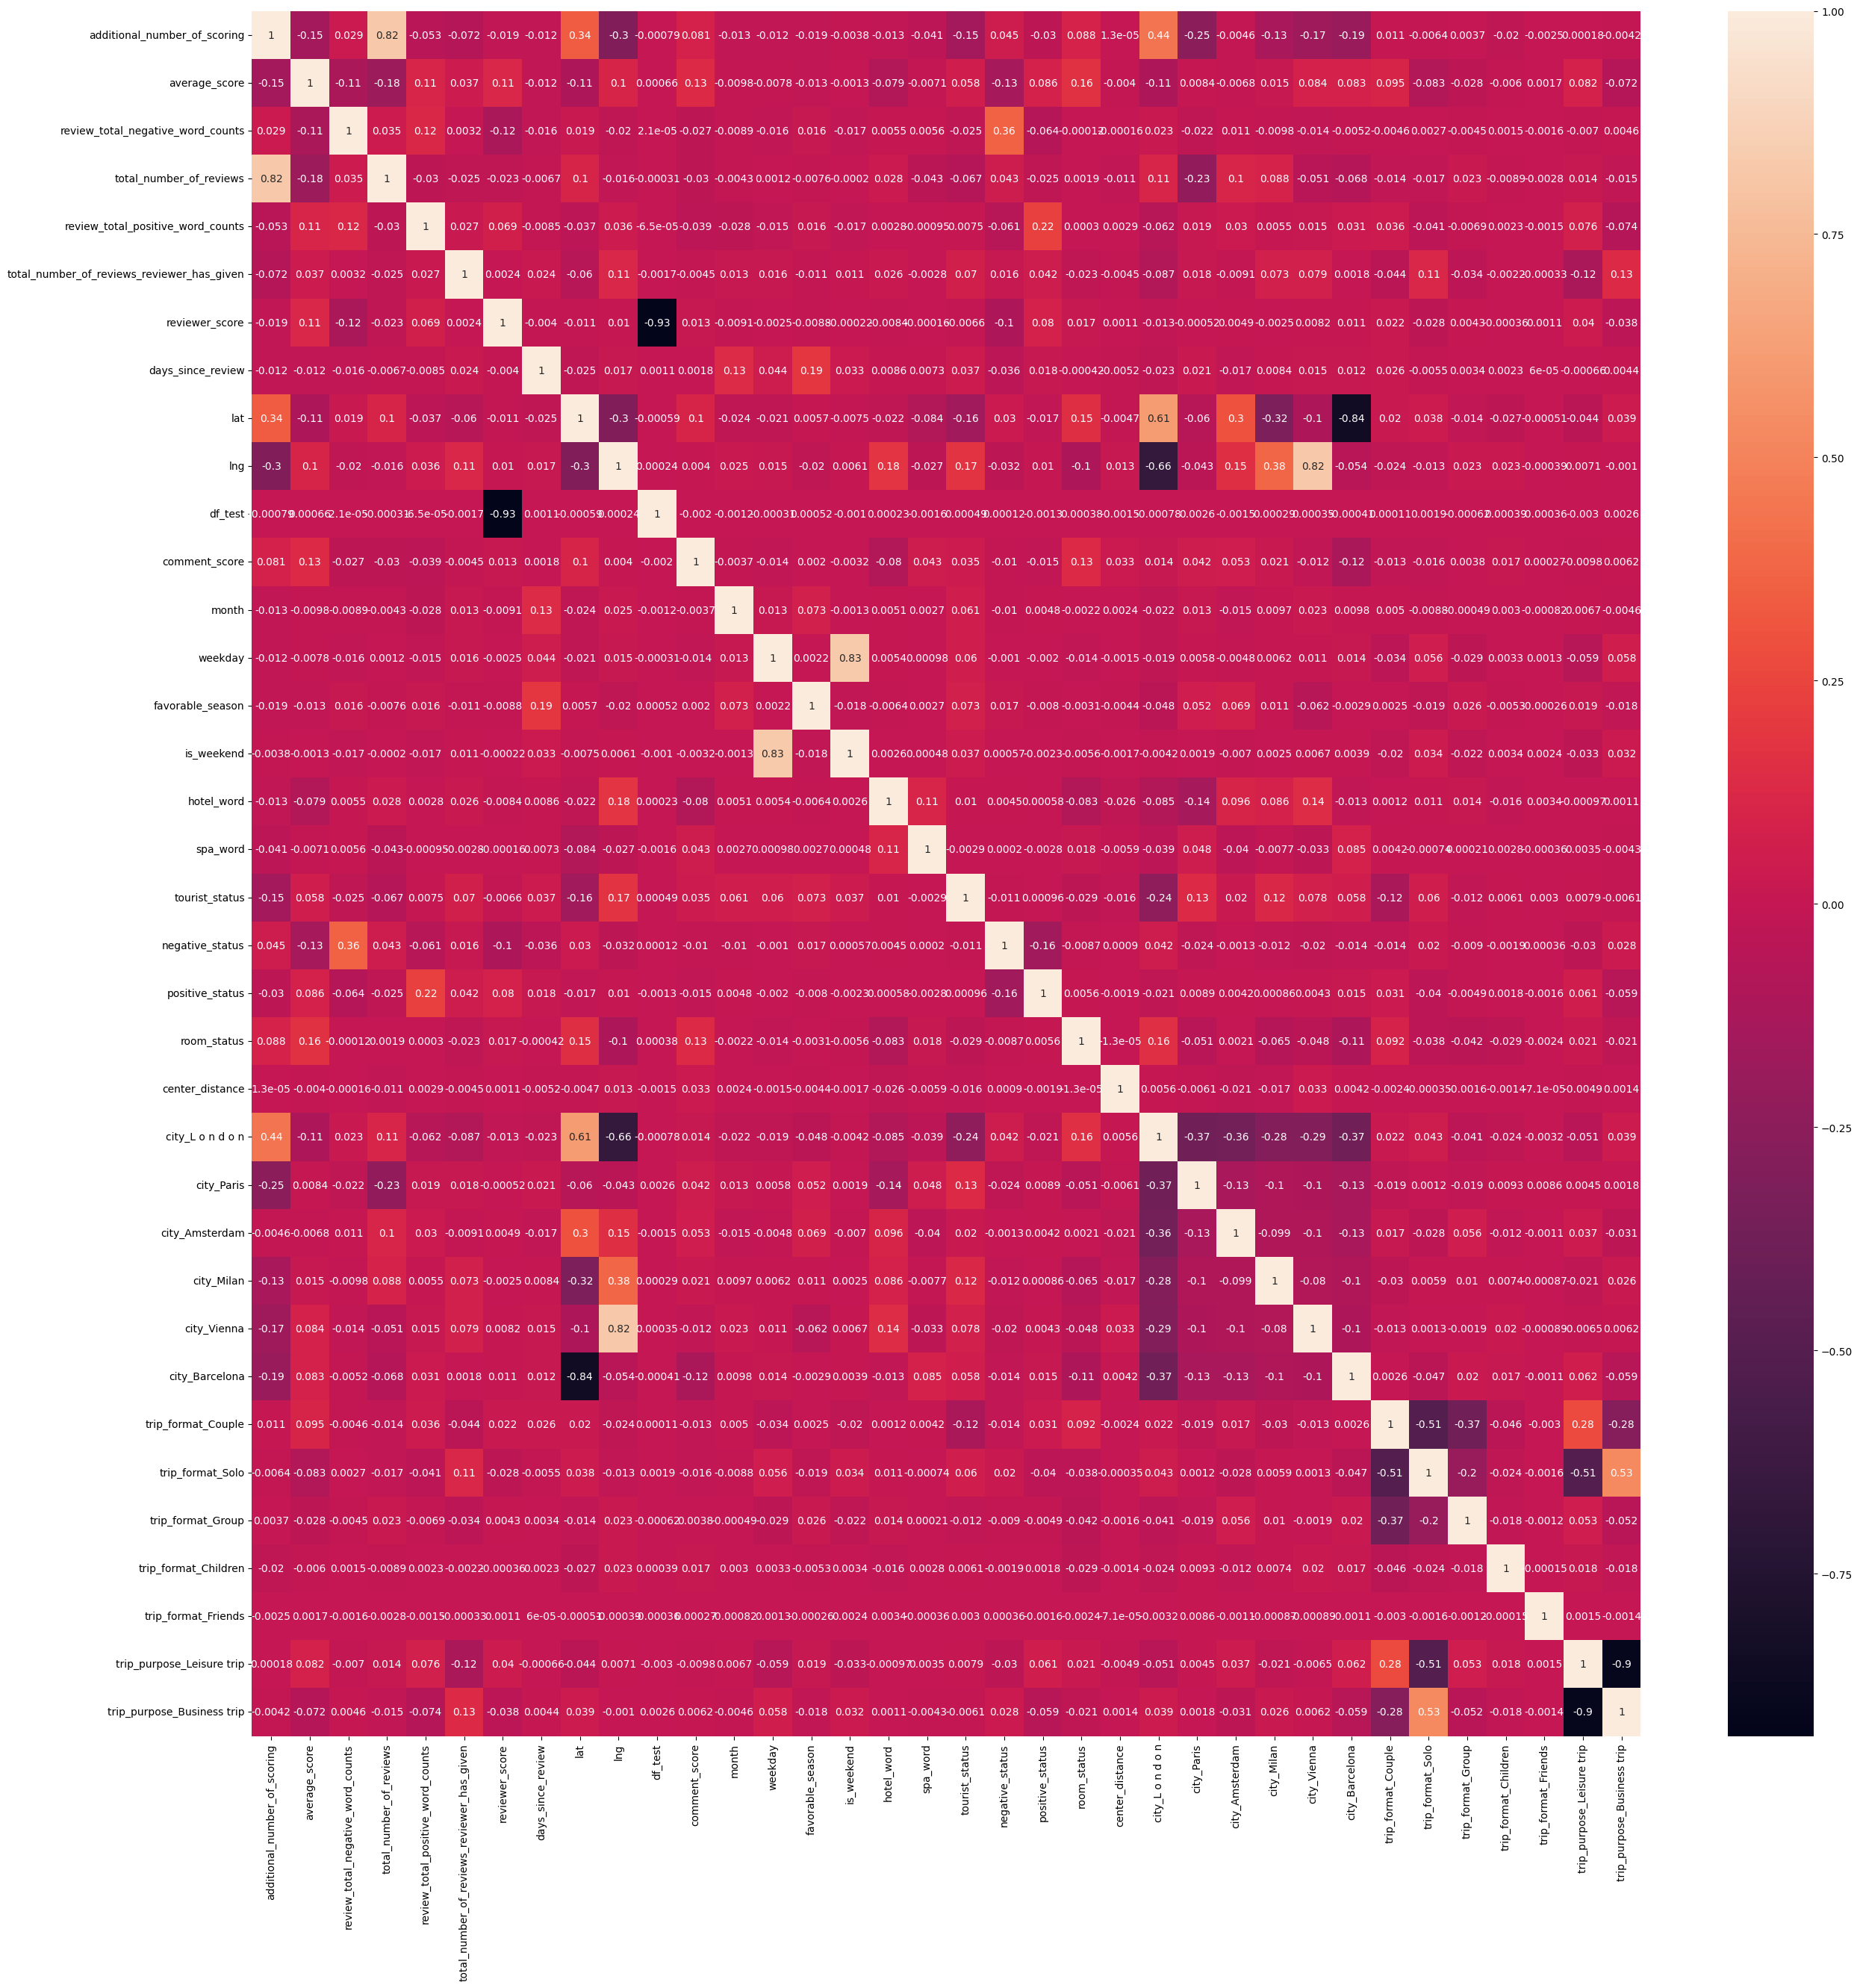

In [59]:
# построим визуализацию матрицы корреляции
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(hotels_select.corr(), annot=True)

In [60]:
# согласно приведенной матрице, нужно удалить один из коррелирующихся столбцов (r>|0.8|)
drop_ = ['total_number_of_reviews', 'lat', 'lng', 'weekday']

hotels_select = hotels_select.drop(drop_, axis = 1)

In [61]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# x - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
train_data = hotels_select[hotels_select['df_test'] == False].drop(['df_test'], axis=1)
test_data = hotels_select[hotels_select['df_test'] == True].drop(['df_test'], axis=1)

y = train_data.reviewer_score.values
x = train_data.drop(['reviewer_score'], axis=1)

In [62]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [63]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)

test_data.shape, train_data.shape, x.shape, x_train.shape, x_test.shape

((128935, 31), (386496, 31), (386496, 30), (309196, 30), (77300, 30))

In [64]:
# посмотрим на получившиеся столбцы
x_train.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'comment_score', 'month', 'favorable_season', 'is_weekend',
       'hotel_word', 'spa_word', 'tourist_status', 'negative_status',
       'positive_status', 'room_status', 'center_distance', 'city_L o n d o n',
       'city_Paris', 'city_Amsterdam', 'city_Milan', 'city_Vienna',
       'city_Barcelona', 'trip_format_Couple', 'trip_format_Solo',
       'trip_format_Group', 'trip_format_Children', 'trip_format_Friends',
       'trip_purpose_Leisure trip', 'trip_purpose_Business trip'],
      dtype='object')

In [65]:
# для оценки значимости разделим признаки

# непрерывные признаки
num_cols = ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'comment_score', 'center_distance']

# категориальные признаки
cat_cols = ['month', 'favorable_season', 'is_weekend', 'hotel_word', 'spa_word', 'tourist_status', 'negative_status',
            'positive_status', 'room_status', 'city_L o n d o n', 'city_Paris', 'city_Amsterdam', 'city_Milan', 'city_Vienna',
            'city_Barcelona', 'trip_format_Couple', 'trip_format_Solo', 'trip_format_Group', 'trip_format_Children', 'trip_format_Friends',
            'trip_purpose_Leisure trip', 'trip_purpose_Business trip']

<Axes: >

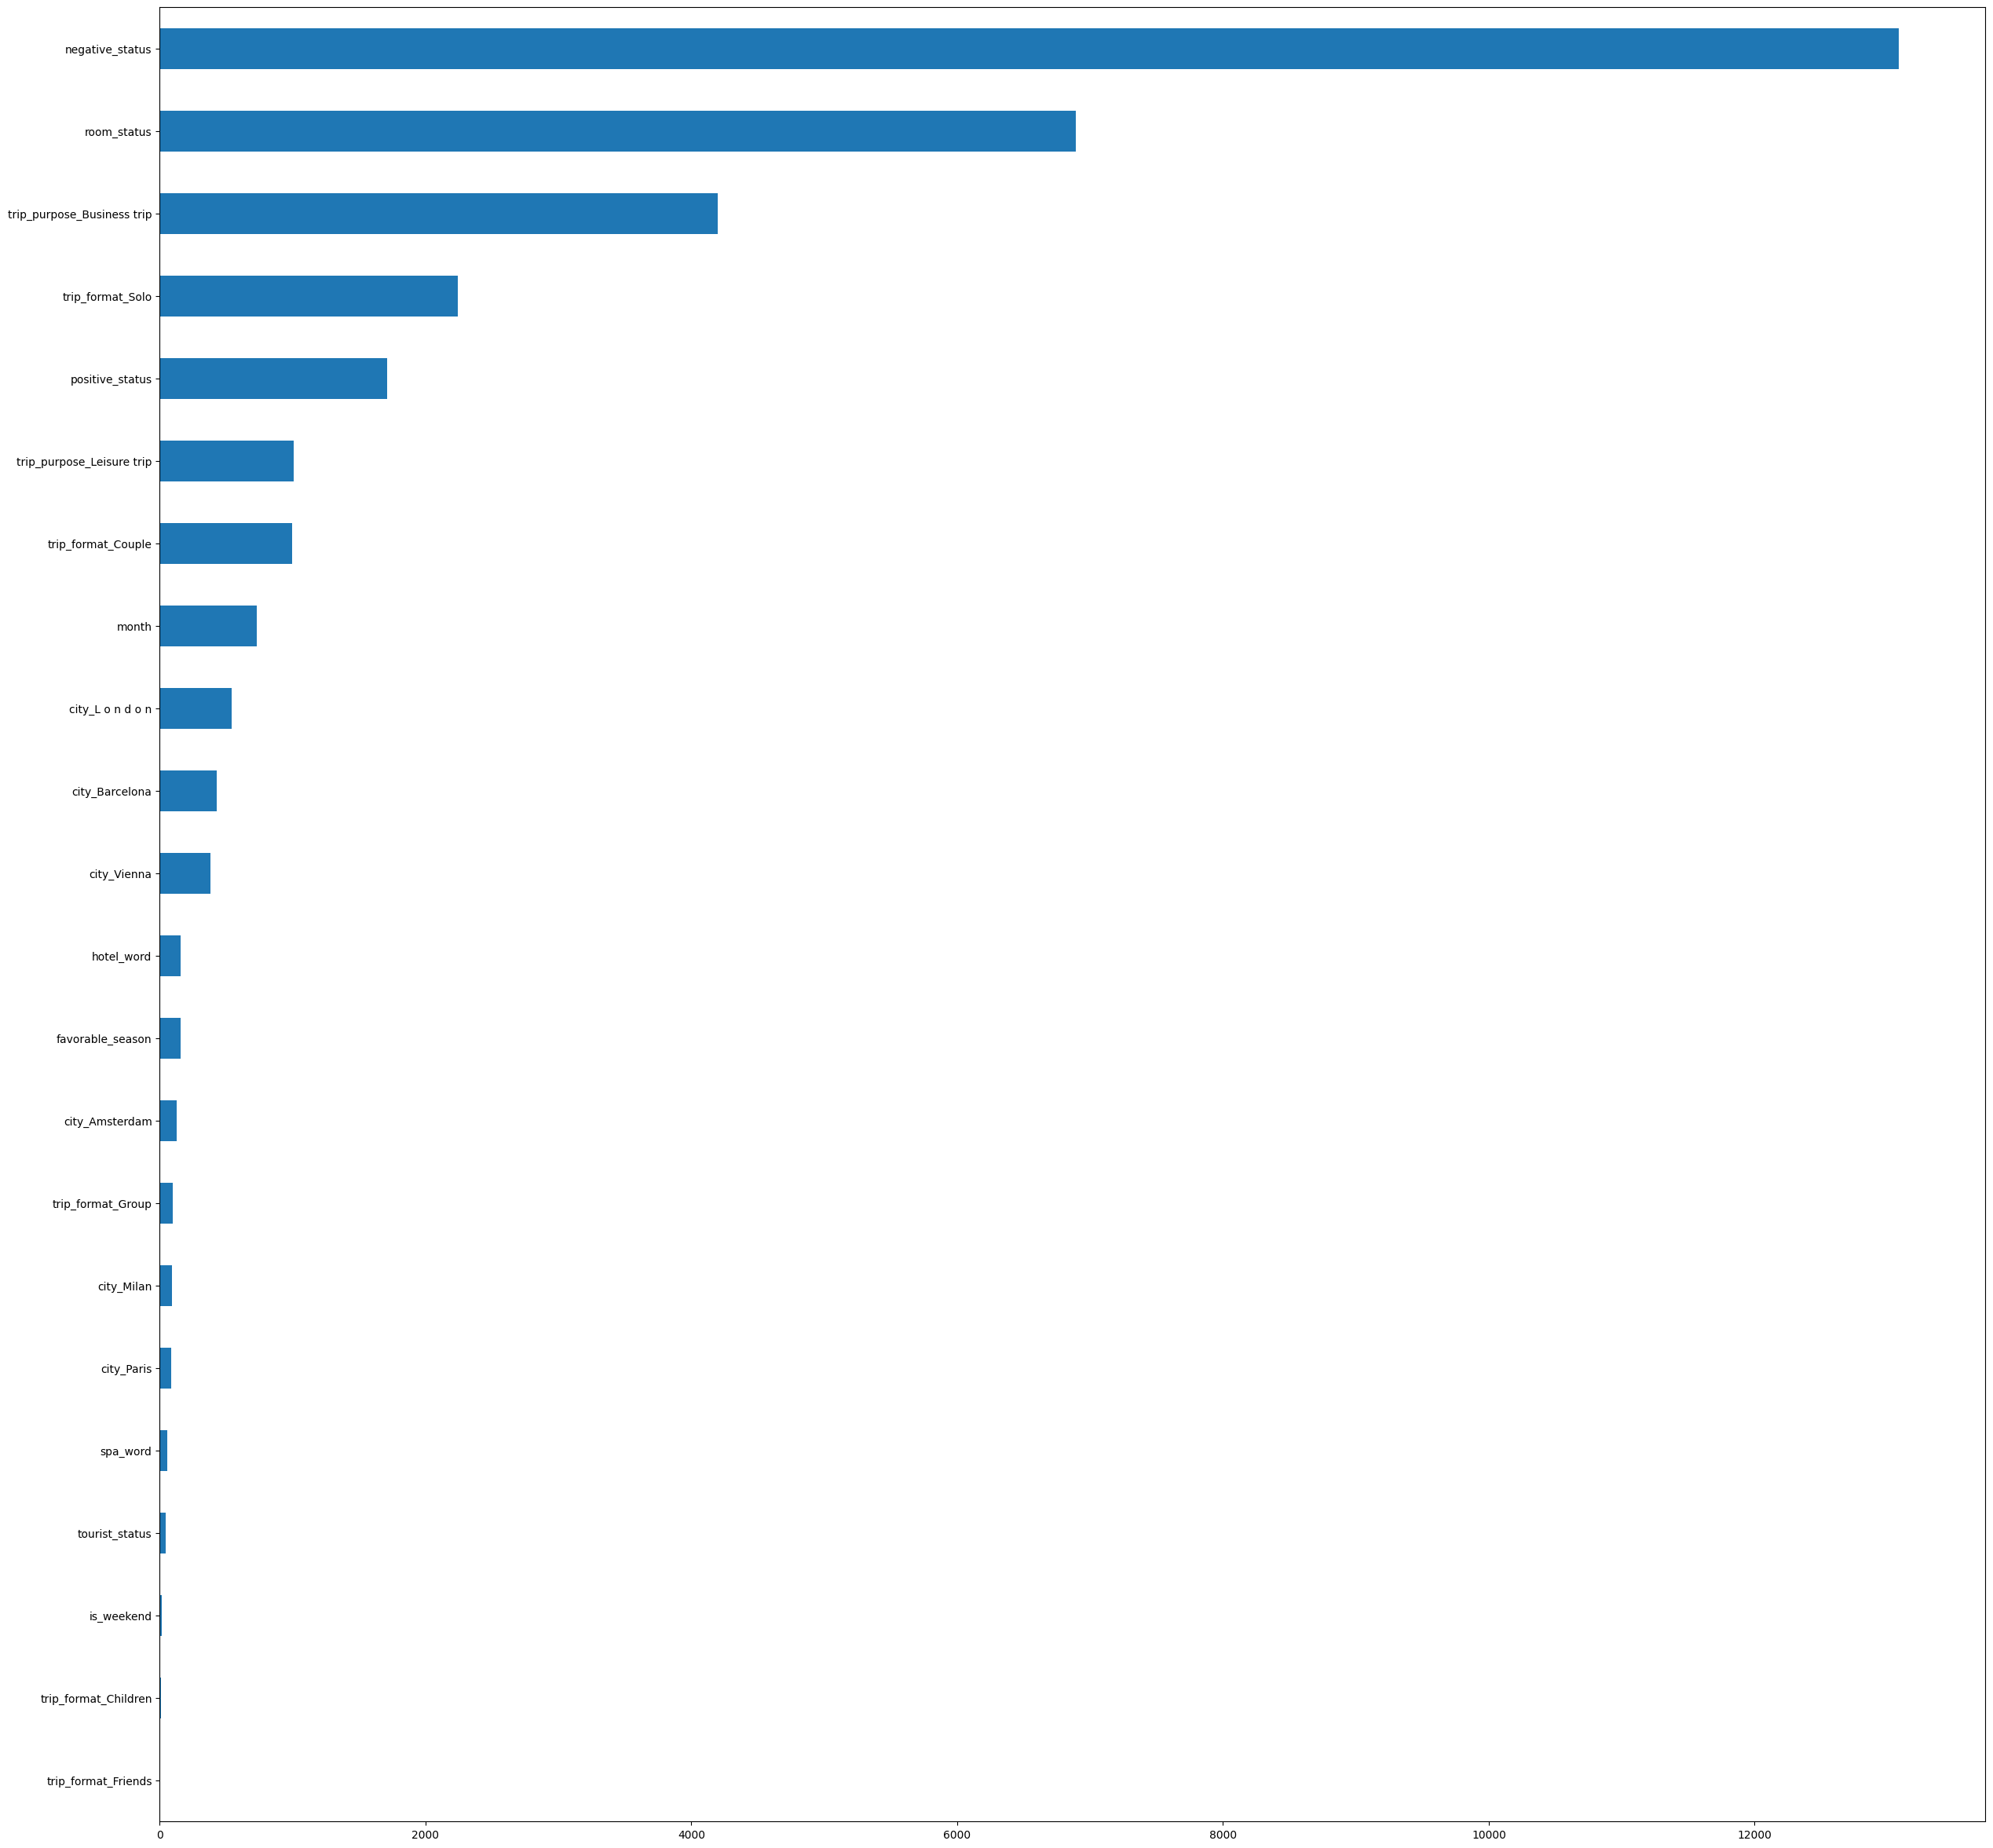

In [66]:
# оценим значимость каждого категориального признака для целевой переменной 
y=y.astype('int')

imp_cat = pd.Series(chi2(x[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<Axes: >

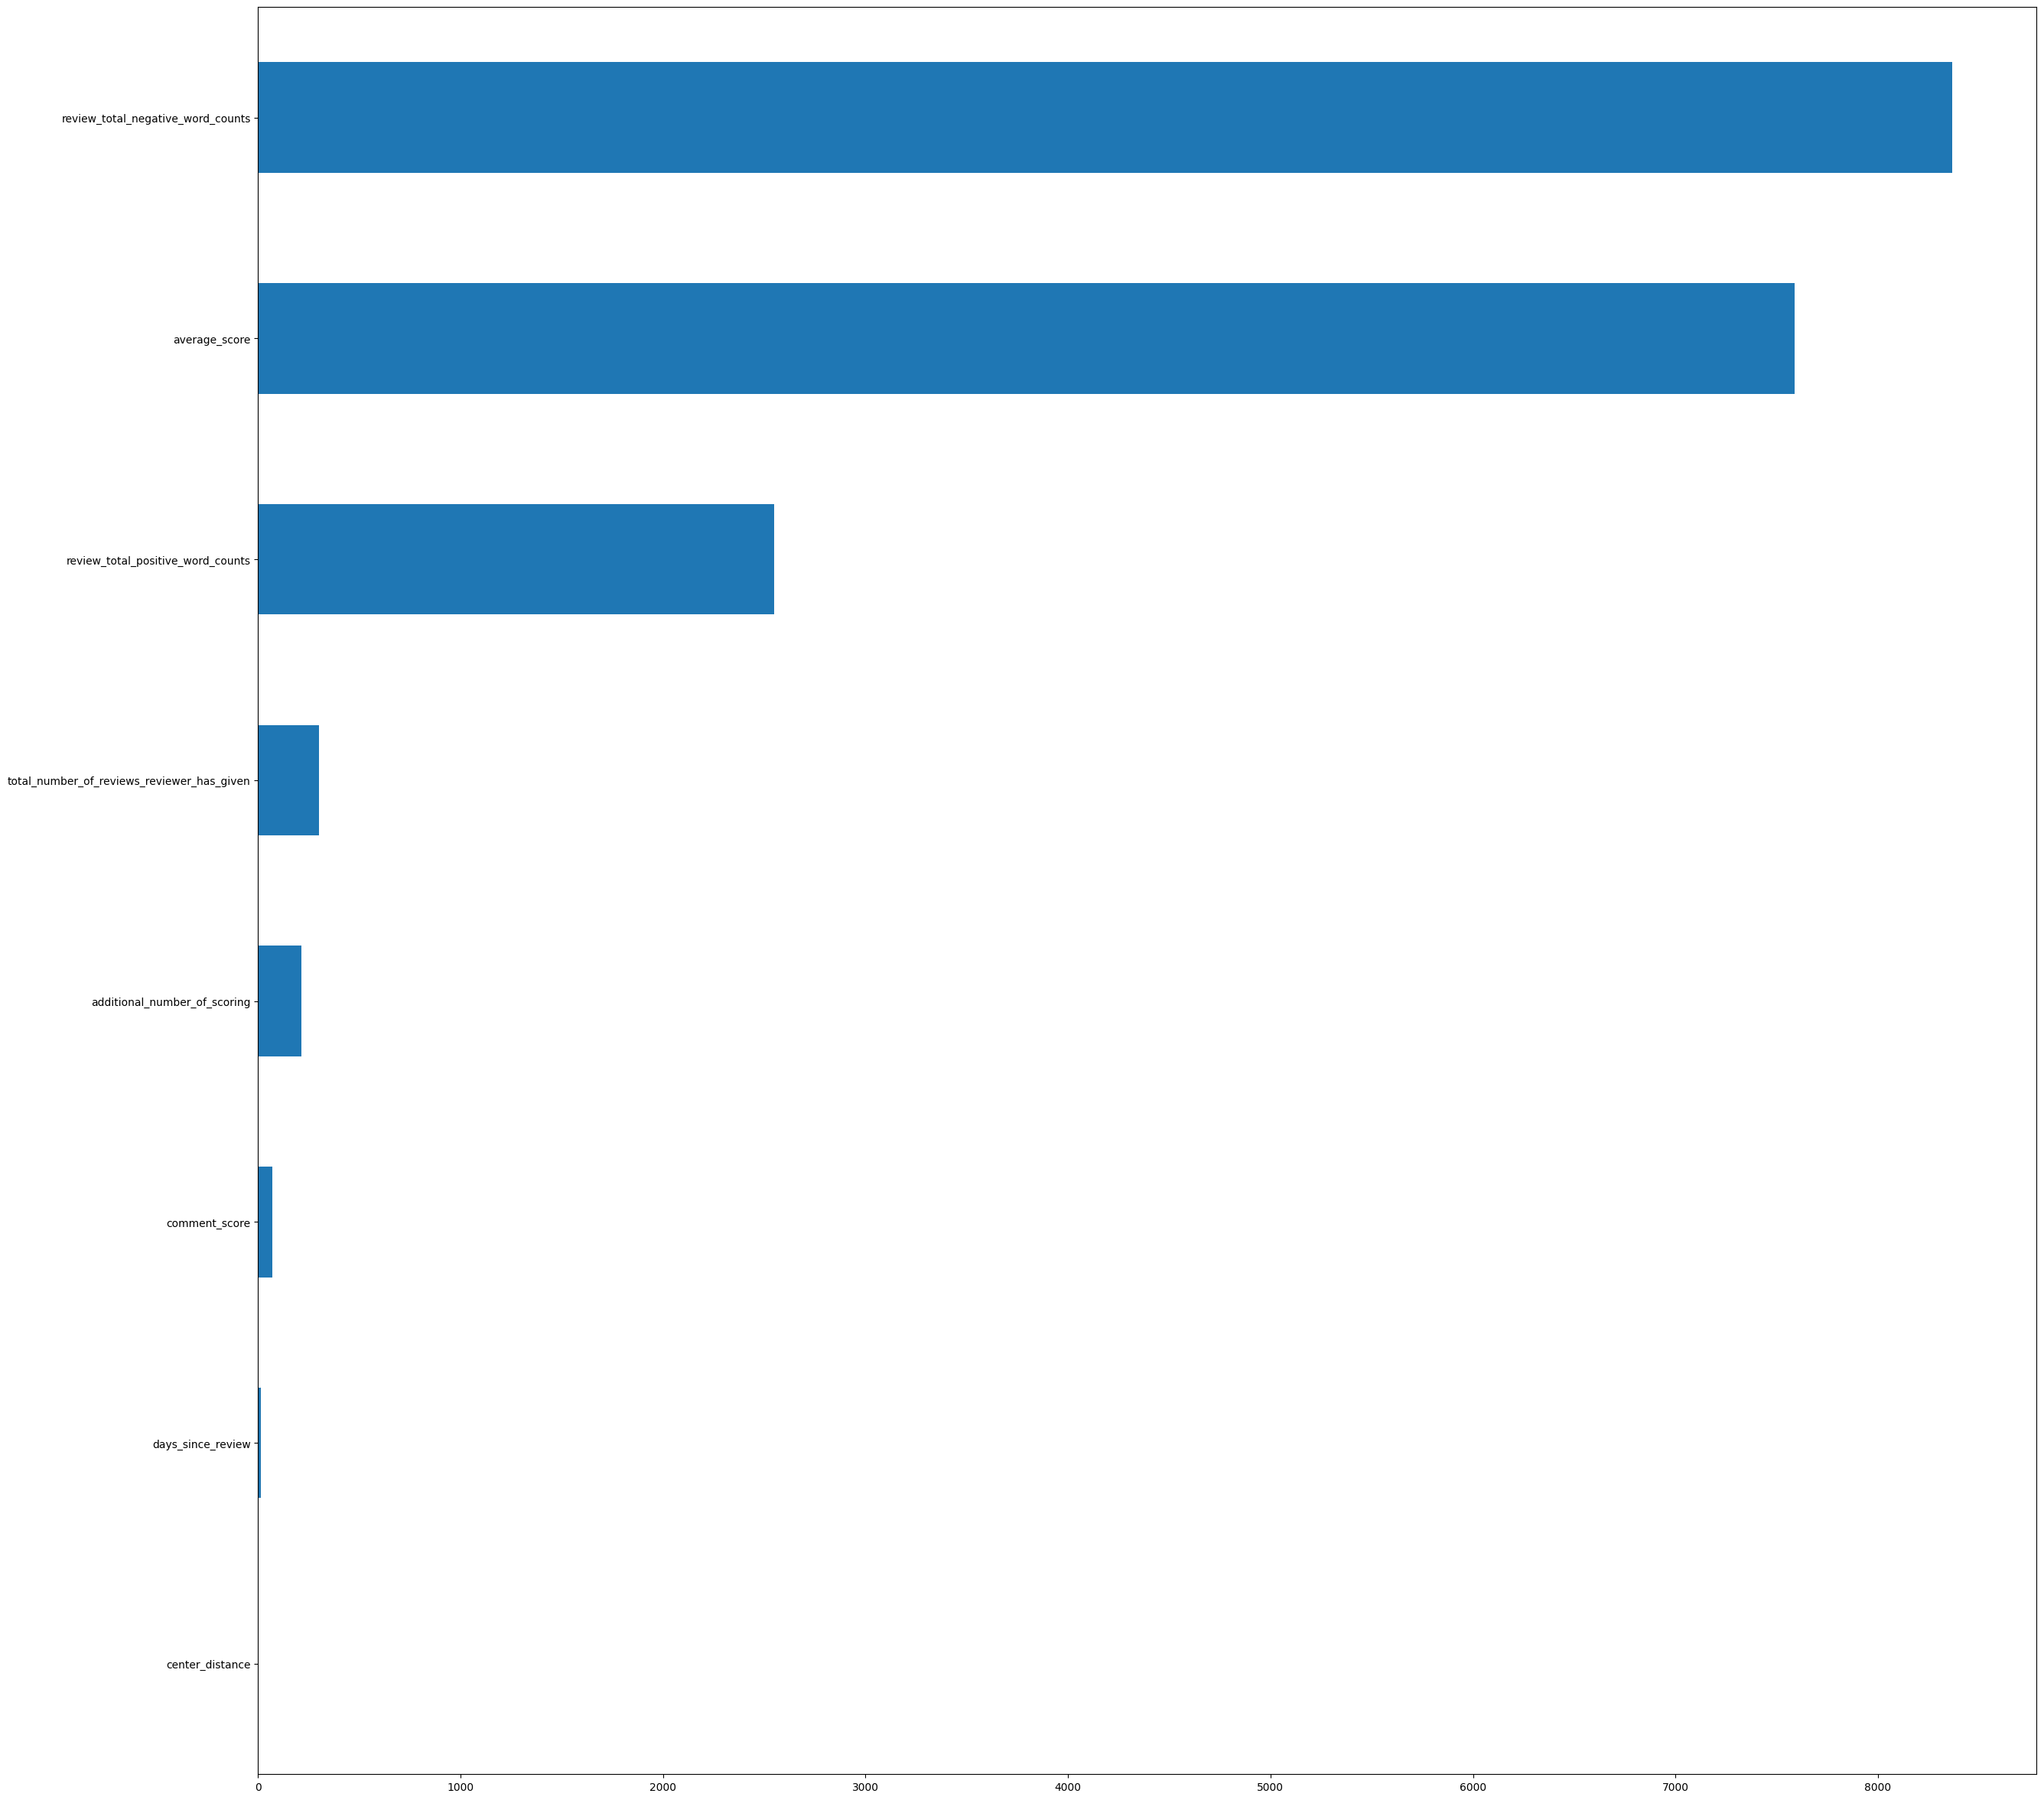

In [67]:
# оценим значимость каждого непрерывного признака для целевой переменной
imp_num = pd.Series(f_classif(x[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

**Вывод**

Топ 5 категориальных признаков:  
1) negative_status (определяет наличие претензий)
2) room_status (определяет тип номера)
3) trip_purpose_Business_trip (определяет тип путешествие как бизнес поездку)
4) trip_format_Solo (определяет ти путешествия как одиночное)
5) positive_status (определяет наличие похвалы)

Топ 5 непрерывных признаков:  
1) review_total_negative_word_counts (определяет количества слов в негативном отзыве)
2) average_score (определяет средний балл отеля, рассчитанный на основе последнего комментария за последний год)
3) review_total_positive_word_counts
4) total_number_of_reviews_reviewer_has_given (количество отзывов, которые рецензенты дали в прошлом)
5) additional_number_of_scoring (определяет количество действительных оценок без проверки)

Таким образом, характер отзыва и его объемность определяет оценку (negative_status, positive_status, review_total_negative_word_counts, review_total_positive_word_counts), при этом негативный отзым имеет более важное значение. Также показано, что на оценку влияет элитность номера, то, является ли поездкой деловой и одиночной. Также средний балл связан со средним баллом, опытностью рецензента (total_number_of_reviews_reviewer_has_given) и количеством оценок без проверки (additional_number_of_scoring)

## 8. Обучение модели

In [68]:
# Создаём модель  
# деревья решений не зависят от масштаба данных, а значит, нормализация не окажет существеннрого влияния на результат
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(x_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(x_test)

In [69]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13638932236579615


In [70]:
# ещё раз посмотрим на пример сабмишна
df_sub.sample(5)

,reviewer_score,id
33280,1,403434
91603,3,385201
72148,6,401883
128553,4,280231
66205,7,391623


In [71]:
# предсказываем значения для test_data
test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = regr.predict(test_data)

predict_submission

array([8.442, 7.594, 8.437, ..., 8.09 , 9.702, 7.713])

In [72]:
# заполняем сабмишн предсказанными значениями и сохраняем
df_sub['reviewer_score'] = predict_submission
df_sub.to_csv('submission.csv', index=False)

df_sub.head(5)

,reviewer_score,id
0,8.442,488440
1,7.594,274649
2,8.437,374688
3,9.396,404352
4,9.542,451596


**Вывод**

Получилось добиться результата MAPE<0.14 благодаря очистки данных и созданию новых признаков